In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [52]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('Fire-Detection',
                                                   shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE)

Found 651 files belonging to 2 classes.


In [7]:
#here class name 1 means fire image and 0 means not fire image
class_name=dataset.class_names
class_name


['0', '1']

In [8]:
len(dataset)

21

In [9]:
for image_batch,lable_batch in dataset.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1]


In [12]:
for image_batch,lable_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[150.25195  142.25195  119.25195 ]
  [151.       143.       120.      ]
  [151.36737  143.36737  120.675964]
  ...
  [144.       128.        95.      ]
  [143.       127.        93.89258 ]
  [143.       127.        93.      ]]

 [[151.       143.       120.      ]
  [151.67467  143.67467  120.67467 ]
  [152.       144.       121.30859 ]
  ...
  [144.       128.        94.24414 ]
  [143.       127.        93.21791 ]
  [143.       127.        93.      ]]

 [[152.16388  144.16388  121.16388 ]
  [152.25977  144.25977  121.259766]
  [153.25977  145.25977  122.56836 ]
  ...
  [144.       128.        94.      ]
  [143.       127.        93.      ]
  [143.       127.        93.      ]]

 ...

 [[104.259766  91.259766  57.259766]
  [104.259766  91.259766  56.259766]
  [104.41406   91.259766  56.259766]
  ...
  [163.       141.        94.      ]
  [164.10742  139.78516   93.89258 ]
  [166.       137.        93.      ]]

 [[102.48828   91.75586   57.      ]
  [104.        91.        56.      ]


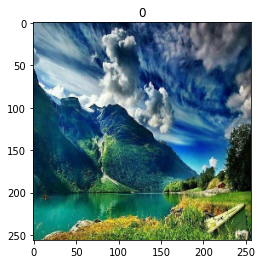

In [20]:
for image_batch,lable_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_name[lable_batch[0]])

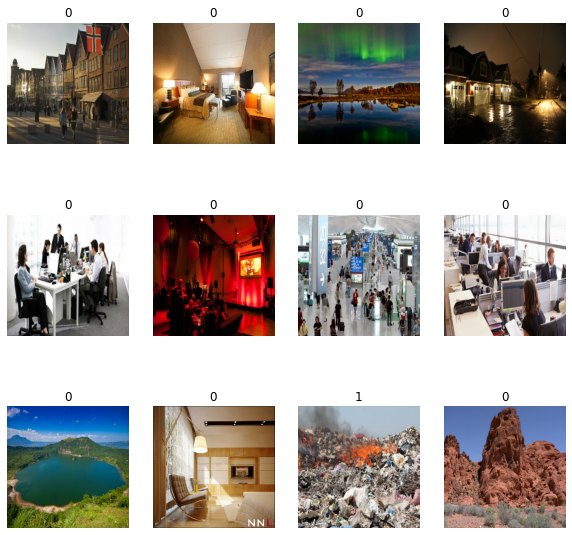

In [22]:
plt.figure(figsize=(10,10))
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[lable_batch[i]])
        plt.axis("off")

In [23]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    
    
    
    return train_ds, val_ds, test_ds


In [26]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

16

In [28]:
len(val_ds)

2

In [29]:
len(test_ds)

2

pre-processing of data

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale=tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
 ])

In [33]:
data_augmentation=tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
 ])

In [36]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])
model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [38]:
model.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
           metrics=['accuracy'])

In [40]:
history=model.fit(
        train_ds,
        epochs=50,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds,
    )

Epoch 1/50
16/16 [==============================] - 63s 3s/step - loss: 0.5297 - accuracy: 0.8452 - val_loss: 0.3566 - val_accuracy: 0.8605
Epoch 2/50
16/16 [==============================] - 46s 3s/step - loss: 0.3900 - accuracy: 0.8432 - val_loss: 0.3696 - val_accuracy: 0.8605
Epoch 3/50
16/16 [==============================] - 45s 3s/step - loss: 0.3218 - accuracy: 0.8534 - val_loss: 0.3029 - val_accuracy: 0.8372
Epoch 4/50
16/16 [==============================] - 53s 3s/step - loss: 0.3252 - accuracy: 0.8452 - val_loss: 0.2797 - val_accuracy: 0.8605
Epoch 5/50
16/16 [==============================] - 51s 3s/step - loss: 0.2740 - accuracy: 0.8758 - val_loss: 0.2273 - val_accuracy: 0.8605
Epoch 6/50
16/16 [==============================] - 51s 3s/step - loss: 0.2455 - accuracy: 0.8880 - val_loss: 0.2107 - val_accuracy: 0.8605
Epoch 7/50
16/16 [==============================] - 56s 4s/step - loss: 0.2737 - accuracy: 0.8880 - val_loss: 0.2570 - val_accuracy: 0.8837
Epoch 8/50
16/16 [==

In [41]:
scores=model.evaluate(test_ds)

2/2 [==============================] - 6s 742ms/step - loss: 0.2069 - accuracy: 0.8906


In [42]:
scores

[0.20690608024597168, 0.890625]

In [43]:
history

In [44]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 16}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
history.history['accuracy']

[0.8452138304710388,
 0.8431771993637085,
 0.8533604741096497,
 0.8452138304710388,
 0.8757637739181519,
 0.8879836797714233,
 0.8879836797714233,
 0.8737270832061768,
 0.8839103579521179,
 0.8757637739181519,
 0.8879836797714233,
 0.9002036452293396,
 0.9002036452293396,
 0.8900203704833984,
 0.9022403359413147,
 0.8981670141220093,
 0.9164969325065613,
 0.9185336232185364,
 0.9266802668571472,
 0.9124236106872559,
 0.9083502888679504,
 0.9226069450378418,
 0.9103869795799255,
 0.9348269104957581,
 0.9368635416030884,
 0.9368635416030884,
 0.9063136577606201,
 0.9287168979644775,
 0.9429734945297241,
 0.9389002323150635,
 0.9246435761451721,
 0.9551934599876404,
 0.9470468163490295,
 0.9266802668571472,
 0.9368635416030884,
 0.9470468163490295,
 0.9287168979644775,
 0.9307535886764526,
 0.9531568288803101,
 0.9450101852416992,
 0.9450101852416992,
 0.9592667818069458,
 0.9551934599876404,
 0.9633401036262512,
 0.9592667818069458,
 0.9735234379768372,
 0.9674134254455566,
 0.9653767943

In [49]:
len(history.history['accuracy'])

50

In [50]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


Text(0.5, 1.0, 'Traning and Validation loss')

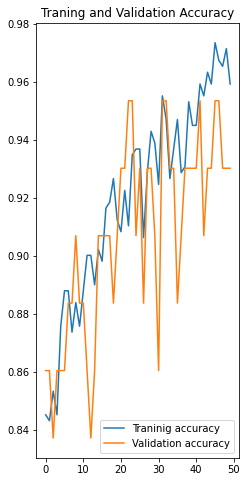

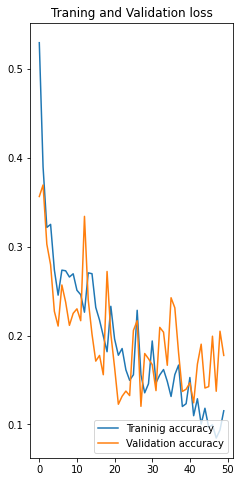

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Traninig accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Traninig accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Traning and Validation loss')

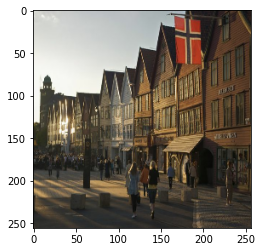

In [68]:
for images_batch, labels_batch in test_ds.take(1):
        plt.imshow(image_batch[0].numpy().astype("uint8"))

first image to predict
actual lable 0
1/1 [==============================] - 1s 790ms/step
predicted_lable 0


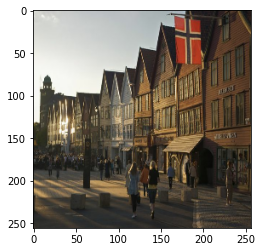

In [86]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
        first_image=image_batch[0].numpy().astype("uint8")
        first_lable=labels_batch[0]
        
        print("first image to predict")
        plt.imshow(first_image)
        print("actual lable",class_name[first_lable])
        
    ##after traning of model predict the model
        batch_prediction=model.predict(images_batch)
        print("predicted_lable",class_name[np.argmax(batch_prediction[0])])

In [100]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    prediction_class=class_name[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])),2)
    return prediction_class,confidence

1/1 [==============================] - 0s 46ms/step


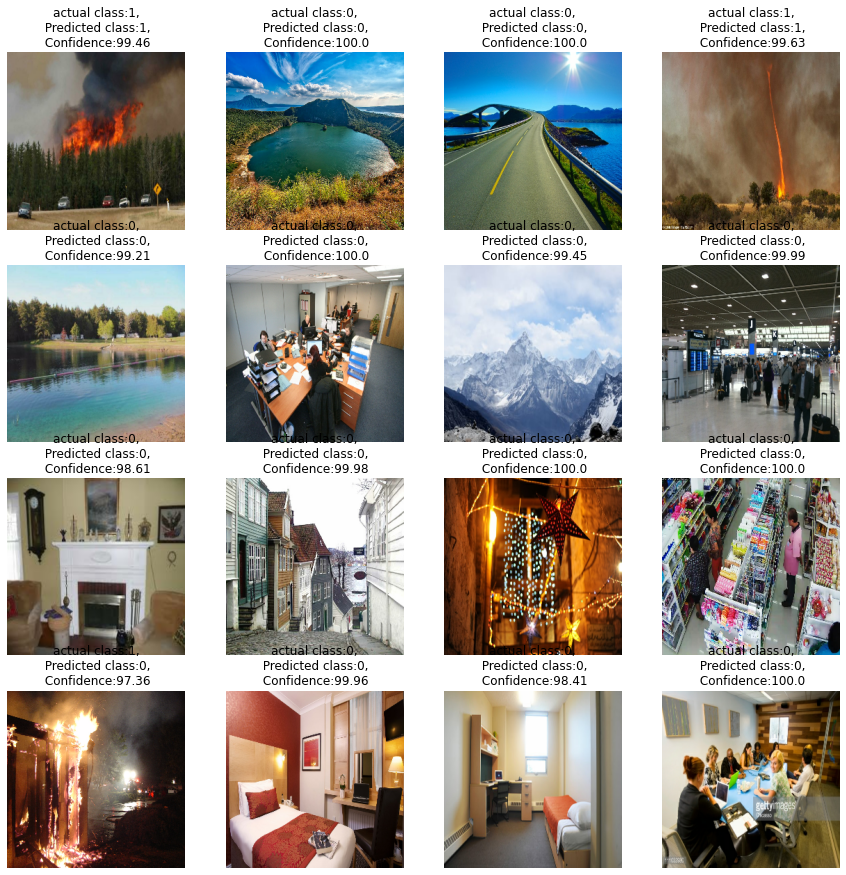

In [111]:
#here class name 1 means fire image and 0 means not fire image
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        prediction_class,confidence=predict(model, images[i].numpy())
        actual_class=class_name[labels[i]]
        plt.title(f"actual class:{actual_class},\n Predicted class:{prediction_class},\n Confidence:{confidence}")
        plt.axis("off")

In [116]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
